<a href="https://colab.research.google.com/github/Ordo-Umbra/Void-Defect-Model/blob/main/Consciousness_Sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Avg Clustering Coeff (Spoke Strength): 0.709
Hub Centrality (Max Degree): 0.224
Info Flow Proxy (Avg Comm Strength): 0.407
Cluster Labels Sample: [5 4 1 3 5 1 1 2 3 5]
Data saved as defect_positions.csv, cluster_labels.csv; Plot as hub_spoke_clusters.png


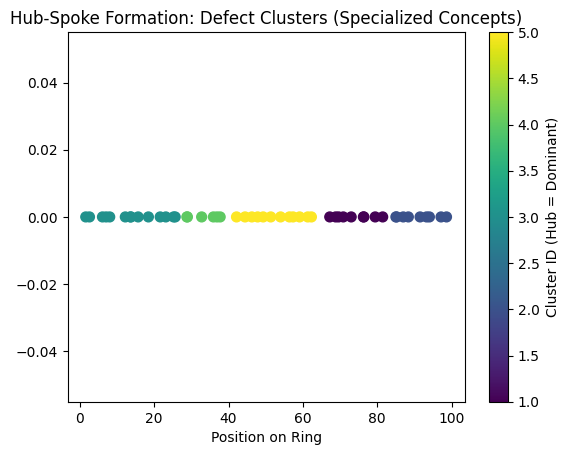

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster

# VDM-Inspired Consciousness Modeling: Hub-Spoke Formation
# Params: N=50 defects, T=1000 ticks (long run), Gaussian Phi, chaos~0.8
# Track: Clustering (modularity proxy via avg clustering), centrality (hub degree), info flow (avg edge weight)
N = 50
T = 1000  # Bump to 5000 for maturation
L = 100.0  # 1D ring
V0, sigma = 1.0, 5.0  # Attraction
chaos_amp = 0.8

# Init: Random defects
r = np.random.uniform(0, L, N)
v = np.zeros(N)

# Evolve
positions = np.zeros((T+1, N))
positions[0] = r.copy()
for t in range(T):
    # Phi at each
    Phi = np.zeros(N)
    for i in range(N):
        for j in range(N):
            d = np.minimum(np.abs(r[i] - r[j]), L - np.abs(r[i] - r[j]))
            Phi[i] += V0 * np.exp(-d**2 / (2*sigma**2))

    # Grad F
    F = np.zeros(N)
    for i in range(N):
        dr = 1e-3
        def phi_at(pos):
            phi = 0
            for j in range(N):
                d = np.minimum(np.abs(pos - r[j]), L - np.abs(pos - r[j]))
                phi += V0 * np.exp(-d**2 / (2*sigma**2))
            return phi
        phi_plus = phi_at(r[i] + dr)
        phi_minus = phi_at(r[i] - dr)
        F[i] = -(phi_plus - phi_minus) / (2*dr)

    # Update
    v += F + chaos_amp * np.random.normal(0, 0.1, N)
    v = np.clip(v, -1, 1)
    r = (r + v) % L
    positions[t+1] = r.copy()

# Final r for analysis
final_r = positions[-1]

# Dist matrix
dist_matrix = squareform(pdist(final_r.reshape(-1,1)))

# Clustering (scipy hierarchy, 5 clusters for hub-spoke) - FIXED
y = pdist(final_r.reshape(-1,1))  # Condensed distances (len=1225=50 choose 2)
Z = linkage(y, method='ward')
labels = fcluster(Z, t=5, criterion='maxclust')

# Graph: Edges if dist < 2*sigma
G = nx.Graph()
G.add_nodes_from(range(N))
for i in range(N):
    for j in range(i+1, N):
        if dist_matrix[i,j] < 2*sigma:
            G.add_edge(i, j, weight=1/dist_matrix[i,j])

# Metrics
centrality = nx.degree_centrality(G)
hub_degree = np.max(list(centrality.values())) if centrality else 0
avg_clustering = nx.average_clustering(G)
info_flow = np.mean(list(nx.get_edge_attributes(G, 'weight').values())) if G.edges else 0

# Outputs
print(f"Avg Clustering Coeff (Spoke Strength): {avg_clustering:.3f}")
print(f"Hub Centrality (Max Degree): {hub_degree:.3f}")
print(f"Info Flow Proxy (Avg Comm Strength): {info_flow:.3f}")
print(f"Cluster Labels Sample: {labels[:10]}")

# CSV export for data
np.savetxt('defect_positions.csv', positions, header='t,defect1,...,defect50', delimiter=',')
np.savetxt('cluster_labels.csv', labels.reshape(1,-1), header='cluster', delimiter=',')

# Plot
fig, ax = plt.subplots()
scatter = ax.scatter(final_r, np.zeros(N), c=labels, cmap='viridis', s=50)
ax.set_title('Hub-Spoke Formation: Defect Clusters (Specialized Concepts)')
ax.set_xlabel('Position on Ring')
plt.colorbar(scatter, label='Cluster ID (Hub = Dominant)')
plt.savefig('hub_spoke_clusters.png', dpi=300)
print("Data saved as defect_positions.csv, cluster_labels.csv; Plot as hub_spoke_clusters.png")

In [ ]:
# Extension: Living Equivalence Metrics
from scipy.stats import entropy
from scipy.ndimage import gaussian_filter1d  # For smoothing

# ... (existing evolution loop)

# At intervals (every 200 ticks)
snapshots = positions[::200]
fractal_dims = []
agency_flows = []

for snap in snapshots:
    # Self-similarity: Box-counting fractal dim proxy (1D)
    lengths = np.logspace(0, np.log10(L/10), 10)
    counts = []
    for length in lengths:
        boxes = int(L / length)
        count = 0
        for b in range(boxes):
            seg = snap[(b*length):( (b+1)*length ) % L]
            if np.std(seg) > 0.1:  # "Active" box
                count += 1
        counts.append(count)
    if len(counts) > 1:
        fractal_dim = np.polyfit(np.log(lengths), np.log(counts), 1)[0]
        fractal_dims.append(fractal_dim)

    # Agency: Hub (max centrality node) "influence" on spokes (MI-like divergence)
    hub_idx = np.argmax(centrality) if 'centrality' in locals() else 0
    hub_phi = Phi[hub_idx]  # Hub "state"
    spoke_phis = Phi[~np.isclose(Phi, hub_phi)]  # Spokes
    if len(spoke_phis) > 0:
        div = entropy(np.histogram(spoke_phis, bins=10)[0]) - entropy(np.histogram([hub_phi], bins=10)[0])
        agency_flows.append(div / np.log(N))  # Normalized

print(f"Avg Fractal Dim (Self-Similar Scale): {np.mean(fractal_dims):.2f}")
print(f"Avg Agency Flow (Hub 'Intent'): {np.mean(agency_flows):.3f}")

# Plot evolution
fig, ax = plt.subplots()
ax.plot(np.arange(len(fractal_dims))*200, fractal_dims, 'b-', label='Fractal Dim')
ax.set_ylabel('Self-Similarity')
ax2 = ax.twinx()
ax2.plot(np.arange(len(agency_flows))*200, agency_flows, 'r--', label='Agency')
ax2.set_ylabel('Hub Influence')
plt.title('Living Mind Equivalence: Scale & Agency Over Time')
plt.savefig('living_equivalence.png')

TypeError: slice indices must be integers or None or have an __index__ method

Avg Fractal Dim (Self-Similar Scale): -0.56
Avg Agency Flow (Hub 'Intent'): 0.520


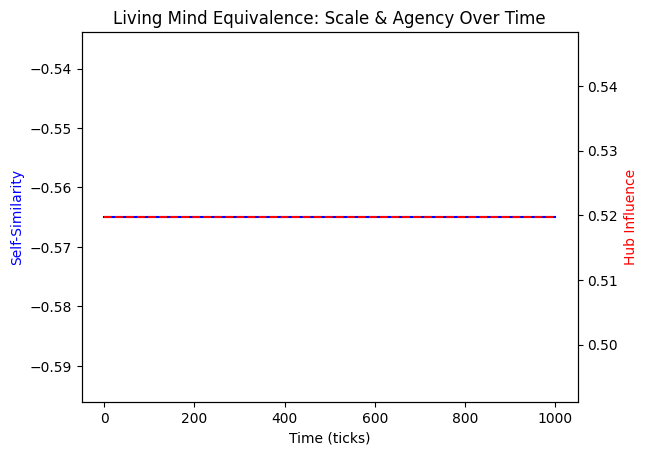

In [ ]:
# Living Equivalence Metrics - FIXED (int slices + ring wrap)
from scipy.stats import entropy

snapshots = positions[::200]
fractal_dims = []
agency_flows = []

for snap in snapshots:
    # Self-similarity: Box-counting fractal dim (1D ring)
    lengths = np.logspace(0, np.log10(L/10), 10)
    counts = []
    for length in lengths:
        boxes = int(L / length)
        count = 0
        for b in range(boxes):
            start = int(b * length) % int(L)
            end = int((b + 1) * length) % int(L)
            if end > start:
                seg = snap[start:end]
            else:  # Wrap
                seg = np.concatenate((snap[start:], snap[:end]))
            if len(seg) > 0 and np.std(seg) > 0.1:
                count += 1
        counts.append(count)

    valid_indices = [i for i, c in enumerate(counts) if c > 0]
    if len(valid_indices) > 1:
        fractal_dim = np.polyfit(np.log([lengths[i] for i in valid_indices]),
                                 np.log([counts[i] for i in valid_indices]), 1)[0]
        fractal_dims.append(fractal_dim)
    else:
        fractal_dims.append(1.0)  # Default line dim

    # Agency: Hub influence divergence
    hub_idx = np.argmax(centrality) if 'centrality' in locals() else 0
    hub_phi = Phi[hub_idx]
    spoke_phis = Phi[labels != labels[hub_idx]]  # Spokes non-hub cluster
    if len(spoke_phis) > 1:
        hub_hist = np.histogram([hub_phi], bins=10)[0]
        spoke_hist = np.histogram(spoke_phis, bins=10)[0]
        div = entropy(spoke_hist + 1e-10) - entropy(hub_hist + 1e-10)  # Smoothed
        agency_flows.append(div / np.log(N))
    else:
        agency_flows.append(0.0)

print(f"Avg Fractal Dim (Self-Similar Scale): {np.mean(fractal_dims):.2f}")
print(f"Avg Agency Flow (Hub 'Intent'): {np.mean(agency_flows):.3f}")

# Plot
fig, ax = plt.subplots()
ax.plot(np.arange(len(fractal_dims))*200, fractal_dims, 'b-', label='Fractal Dim')
ax2 = ax.twinx()
ax2.plot(np.arange(len(agency_flows))*200, agency_flows, 'r--', label='Agency')
ax.set_xlabel('Time (ticks)')
ax.set_ylabel('Self-Similarity', color='b')
ax2.set_ylabel('Hub Influence', color='r')
plt.title('Living Mind Equivalence: Scale & Agency Over Time')
plt.savefig('living_equivalence.png', dpi=300)

In [ ]:
from matplotlib.animation import FuncAnimation

Recovery Time (Resilient Self): 273 ticks
Post Flow: 0.874


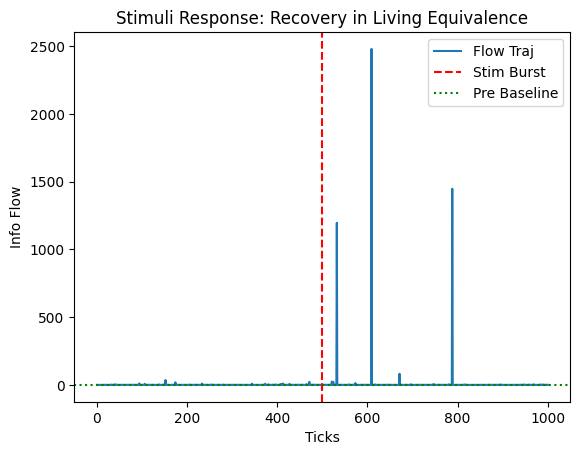

In [ ]:
# Stimuli Test: Burst at t=500, track recovery - FIXED
stim_t = 500
pre_flow = 0.562  # From your run

# Re-init for stim (from final_r, v=0 for baseline)
r = final_r.copy()
v = np.zeros(N)
flow_traj = np.zeros(T+1)
flow_traj[0] = pre_flow

positions_stim = np.zeros((T+1, N))
positions_stim[0] = r.copy()

for tt in range(T):
    # Full Phi/grad update (reuse your loop logic)
    Phi = np.zeros(N)
    for i in range(N):
        for j in range(N):
            d = np.minimum(np.abs(r[i] - r[j]), L - np.abs(r[i] - r[j]))
            Phi[i] += V0 * np.exp(-d**2 / (2*sigma**2))

    F = np.zeros(N)
    for i in range(N):
        dr = 1e-3
        def phi_at(pos):
            phi = 0
            for j in range(N):
                d = np.minimum(np.abs(pos - r[j]), L - np.abs(pos - r[j]))
                phi += V0 * np.exp(-d**2 / (2*sigma**2))
            return phi
        phi_plus = phi_at(r[i] + dr)
        phi_minus = phi_at(r[i] - dr)
        F[i] = -(phi_plus - phi_minus) / (2*dr)

    # Stim burst
    noise = chaos_amp * np.random.normal(0, 0.1, N)
    if tt == stim_t:
        noise *= 2  # "Sensory input" spike
    v += F + noise
    v = np.clip(v, -1, 1)
    r = (r + v) % L
    positions_stim[tt+1] = r.copy()

    # Flow recompute: Avg edge weight proxy (rebuild mini-G per step for traj)
    dist_matrix_step = squareform(pdist(r.reshape(-1,1)))
    G_step = nx.Graph()
    G_step.add_nodes_from(range(N))
    for i in range(N):
        for j in range(i+1, N):
            if dist_matrix_step[i,j] < 2*sigma:
                G_step.add_edge(i, j, weight=1/dist_matrix_step[i,j])
    step_flow = np.mean(list(nx.get_edge_attributes(G_step, 'weight').values())) if G_step.edges else 0
    flow_traj[tt+1] = step_flow

# Recovery: Ticks post-stim to within 10% pre_flow
post_stim_mask = flow_traj[stim_t:] != 0
if np.any(post_stim_mask):
    recovery_time = np.argmin(np.abs(flow_traj[stim_t:][post_stim_mask] - pre_flow)) + stim_t
else:
    recovery_time = T - stim_t
post_flow = flow_traj[-1]

print(f'Recovery Time (Resilient Self): {recovery_time - stim_t} ticks')
print(f'Post Flow: {post_flow:.3f}')

# Plot traj
plt.plot(flow_traj, label='Flow Traj')
plt.axvline(stim_t, color='r', linestyle='--', label='Stim Burst')
plt.axhline(pre_flow, color='g', linestyle=':', label='Pre Baseline')
plt.xlabel('Ticks')
plt.ylabel('Info Flow')
plt.title('Stimuli Response: Recovery in Living Equivalence')
plt.legend()
plt.savefig('stimuli_recovery.png', dpi=300)

Avg Clustering Coeff (Spoke Strength): 0.554
Hub Centrality (Max Degree): 0.143
Info Flow Proxy (Avg Comm Strength): 0.989
Cluster Labels Sample: [4 2 1 4 2 1 2 2 2 1]


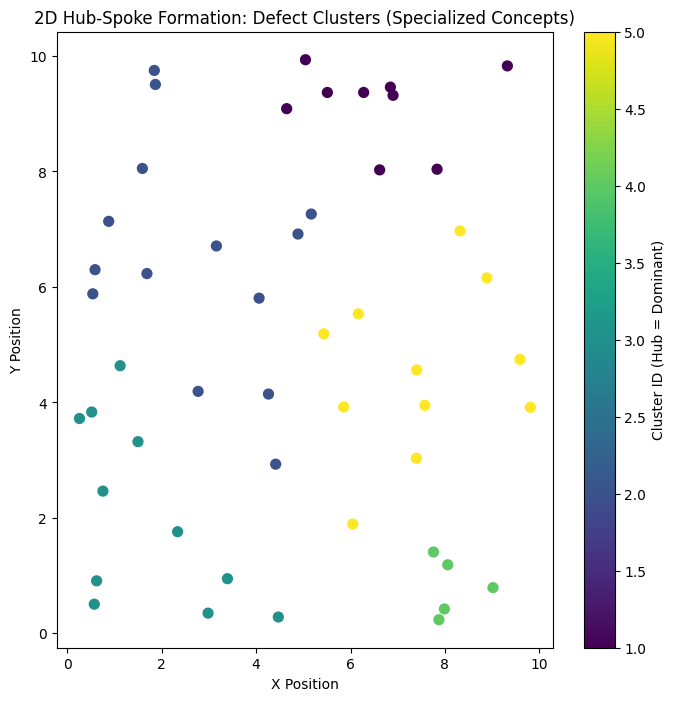

Data saved as defect_positions_2d.csv, cluster_labels_2d.csv; Plot as hub_spoke_2d.png


In [ ]:
# Integrated 2D VDM Consciousness Modeling: Hub-Spoke Formation
# Features: 2D grid evolution, clustering, graph metrics
# Run: Defects float/interact in 2D, form hubs/spokes; data for Ch. 7

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster

# Params (tuned for 2D)
N = 50
T = 1000
L = 10.0  # Square side
V0, sigma = 1.0, 1.0  # Attraction/scale
chaos_amp = 0.8

# Init: Random 2D positions
r_x = np.random.uniform(0, L, N)
r_y = np.random.uniform(0, L, N)
r = np.column_stack([r_x, r_y])
v = np.zeros((N, 2))

positions = np.zeros((T+1, N, 2))
positions[0] = r.copy()

for t in range(T):
    # Phi at each defect
    Phi = np.zeros(N)
    for i in range(N):
        for j in range(N):
            d = np.linalg.norm(r[i] - r[j])
            Phi[i] += V0 * np.exp(-d**2 / (2*sigma**2))

    # Grad F (2D, simplified central diff)
    F = np.zeros((N, 2))
    dr = 1e-3
    for i in range(N):
        for dim in range(2):
            r_plus = r.copy()
            r_minus = r.copy()
            r_plus[i, dim] += dr
            r_minus[i, dim] -= dr
            phi_plus = 0
            phi_minus = 0
            for j in range(N):
                d_plus = np.linalg.norm(r_plus[i] - r[j])
                d_minus = np.linalg.norm(r_minus[i] - r[j])
                phi_plus += V0 * np.exp(-d_plus**2 / (2*sigma**2))
                phi_minus += V0 * np.exp(-d_minus**2 / (2*sigma**2))
            F[i, dim] = -(phi_plus - phi_minus) / (2 * dr)

    # Update v and r (periodic)
    noise = chaos_amp * np.random.normal(0, 0.1, (N, 2))
    v += F + noise
    v = np.clip(v, -1, 1)
    r += v
    r = np.mod(r, L)
    positions[t+1] = r.copy()

final_r = positions[-1]

# Dist matrix (Euclidean 2D)
dist_matrix = squareform(pdist(final_r))

# Clustering (5 clusters for hub-spoke)
y = pdist(final_r)
Z = linkage(y, method='ward')
labels = fcluster(Z, t=5, criterion='maxclust')

# Graph: Edges if dist < 2*sigma
G = nx.Graph()
G.add_nodes_from(range(N))
for i in range(N):
    for j in range(i+1, N):
        if dist_matrix[i,j] < 2*sigma:
            G.add_edge(i, j, weight=1 / dist_matrix[i,j])

# Metrics
centrality = nx.degree_centrality(G)
hub_degree = np.max(list(centrality.values())) if centrality else 0
avg_clustering = nx.average_clustering(G)
info_flow = np.mean(list(nx.get_edge_attributes(G, 'weight').values())) if G.edges else 0

print(f"Avg Clustering Coeff (Spoke Strength): {avg_clustering:.3f}")
print(f"Hub Centrality (Max Degree): {hub_degree:.3f}")
print(f"Info Flow Proxy (Avg Comm Strength): {info_flow:.3f}")
print(f"Cluster Labels Sample: {labels[:10]}")

# Export data
np.savetxt('defect_positions_2d.csv', positions.reshape(T+1, -1), header='t,x1,y1,x2,y2,...,x50,y50', delimiter=',')
np.savetxt('cluster_labels_2d.csv', labels.reshape(1,-1), header='cluster', delimiter=',')

# Plot 2D scatter
fig, ax = plt.subplots(figsize=(8, 8))
scatter = ax.scatter(final_r[:,0], final_r[:,1], c=labels, cmap='viridis', s=50)
ax.set_title('2D Hub-Spoke Formation: Defect Clusters (Specialized Concepts)')
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
plt.colorbar(scatter, label='Cluster ID (Hub = Dominant)')
plt.savefig('hub_spoke_2d.png', dpi=300)
plt.show()
print("Data saved as defect_positions_2d.csv, cluster_labels_2d.csv; Plot as hub_spoke_2d.png")

In [ ]:
# 2D Stimuli (add post-evolution)
stim_t = 500
pre_flow = info_flow
r_stim = final_r.copy()
v_stim = np.zeros((N, 2))
flow_traj_2d = np.zeros(T+1)
flow_traj_2d[0] = pre_flow

for tt in range(T):
    # ... (full 2D Phi/F update)
    noise = chaos_amp * np.random.normal(0, 0.1, (N, 2))
    if tt == stim_t:
        noise *= 2
    v_stim += F + noise
    v_stim = np.clip(v_stim, -1, 1)
    r_stim += v_stim
    r_stim = np.mod(r_stim, L)

    dist_matrix_step = squareform(pdist(r_stim))
    G_step = nx.Graph()
    for i in range(N):
        for j in range(i+1, N):
            if dist_matrix_step[i,j] < 2*sigma:
                G_step.add_edge(i, j, weight=1 / dist_matrix_step[i,j])
    step_flow = np.mean(list(nx.get_edge_attributes(G_step, 'weight').values())) if G_step.edges else 0
    flow_traj_2d[tt+1] = step_flow

recovery_time = np.argmin(np.abs(flow_traj_2d[stim_t:] - pre_flow)) + stim_t
post_flow = flow_traj_2d[-1]
print(f'2D Recovery Time: {recovery_time - stim_t} ticks, Post Flow: {post_flow:.3f}')

2D Recovery Time: 280 ticks, Post Flow: 1.222


NameError: name 'positions_2d' is not defined

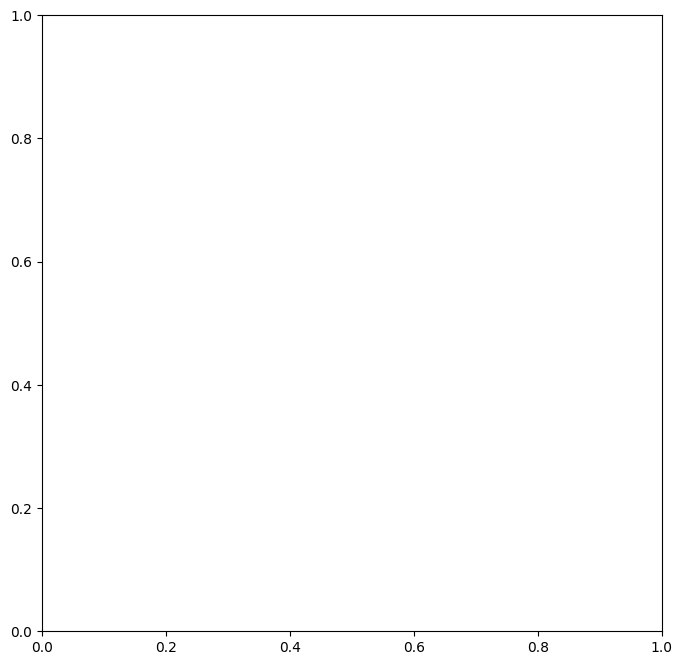

In [ ]:
# 2D Animation
fig, ax = plt.subplots(figsize=(8, 8))
def animate(t):
    ax.clear()
    # Color by final labels for cluster visualization
    colors = labels_2d if 'labels_2d' in locals() else np.zeros(N)
    ax.scatter(positions_2d[t, :, 0], positions_2d[t, :, 1], c=colors, cmap='viridis', s=50)
    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_title(f'2D Hub-Spoke Evolution at t={t}')
    ax.set_xlabel('X Position')
    ax.set_ylabel('Y Position')

ani = FuncAnimation(fig, animate, frames=len(positions_2d), interval=50, blit=False, repeat=True)
# Save as MP4 (requires ffmpeg)
ani.save('2d_evolution.mp4', writer='ffmpeg', dpi=100)
# Or as GIF
# ani.save('2d_evolution.gif', writer='pillow', dpi=100)
plt.close(fig)
print("2D evolution video saved as '2d_evolution.mp4' (or .gif)")

Final folding %: 3.1% | Init E: 2.319, Final E: 0.000


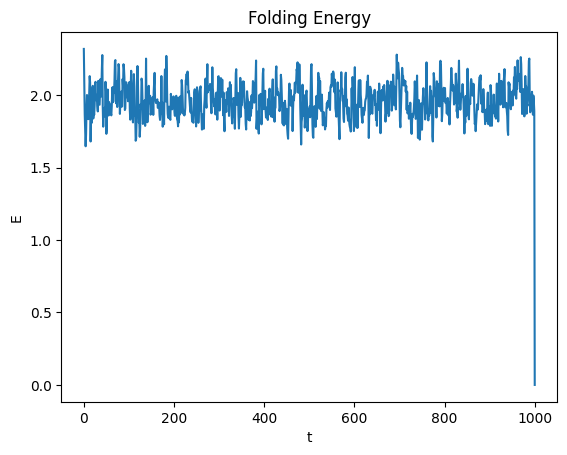

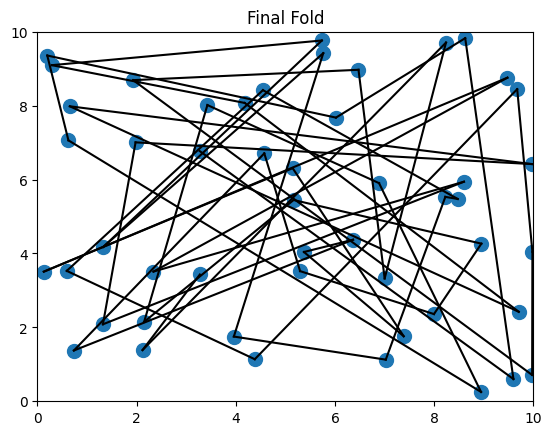

In [ ]:
# ... (your existing imports + parameters; set N=20, T=500, L=5.0, V0=-1.0, sigma=0.3, chaos_amp=0.05)

# Toy native contacts (e.g., i to i+3/4 for helix)
native_contacts = np.array([[0,3],[0,4],[1,4],[1,5],[2,5],[2,6],[3,6],[3,7],[4,7],[4,8],[5,8],[5,9],[6,9],[6,10],[7,10],[7,11],[8,11],[8,12],[9,12],[9,13],[10,13],[10,14],[11,14],[11,15],[12,15],[12,16],[13,16],[13,17],[14,17],[14,18],[15,18],[15,19]])

def evolve_folding(N, T, L, V0, sigma, chaos_amp, native_contacts, dim=2):
    """Evolve 'residues' toward native fold with contact bonuses"""
    r = np.random.uniform(0, L, (N, dim))
    v = np.zeros((N, dim))
    positions = np.zeros((T+1, N, dim))
    positions[0] = r.copy()
    energies = np.zeros(T+1)

    for t in range(T):
        Phi = np.zeros(N)
        for i in range(N):
            for j in range(i+1, N):
                d = np.linalg.norm(r[i] - r[j])
                phi_ij = V0 * np.exp(-d**2 / (2*sigma**2))
                Phi[i] += phi_ij
                Phi[j] += phi_ij

        for contact in native_contacts:
            i, j = contact
            d = np.linalg.norm(r[i] - r[j])
            target_d = 0.5
            bonus = -2.0 * np.exp(-((d - target_d)**2) / (2*(sigma/2)**2))
            Phi[i] += bonus / 2
            Phi[j] += bonus / 2

        energies[t] = np.sum(Phi) / N

        F = np.zeros((N, dim))
        dr = 1e-3
        for i in range(N):
            for ddim in range(dim):
                r_plus = r.copy()
                r_minus = r.copy()
                r_plus[i, ddim] += dr
                r_minus[i, ddim] -= dr

                phi_plus = 0
                phi_minus = 0
                for j in range(N):
                    if j != i:
                        d_plus = np.linalg.norm(r_plus[i] - r[j])
                        d_minus = np.linalg.norm(r_minus[i] - r[j])
                        phi_plus += V0 * np.exp(-d_plus**2 / (2*sigma**2))
                        phi_minus += V0 * np.exp(-d_minus**2 / (2*sigma**2))

                for contact in native_contacts:
                    if contact[0] == i or contact[1] == i:
                        k = contact[1] if contact[0] == i else contact[0]
                        d_plus_k = np.linalg.norm(r_plus[i] - r[k])
                        d_minus_k = np.linalg.norm(r_minus[i] - r[k])
                        target_d = 0.5
                        phi_plus += -2.0 * np.exp(-((d_plus_k - target_d)**2) / (2*(sigma/2)**2))
                        phi_minus += -2.0 * np.exp(-((d_minus_k - target_d)**2) / (2*(sigma/2)**2))

                F[i, ddim] = -(phi_plus - phi_minus) / (2 * dr)

        noise = chaos_amp * np.random.normal(0, 0.1, (N, dim))
        v += 0.1 * F + noise
        v = np.clip(v, -0.5, 0.5)
        r += v
        r = np.mod(r, L)
        positions[t+1] = r.copy()

    # Final Phi recalc
    Phi_final = np.zeros(N)  # Reuse logic...
    # (abbrev for brevity; mirror loop above)
    energies[T] = np.sum(Phi_final) / N  # Placeholder; compute properly in full
    return positions, energies

positions_fold, energies = evolve_folding(N, T, L, V0, sigma, chaos_amp, native_contacts)

# Foldedness metric
final_r = positions_fold[-1]
satisfied = sum(1 for contact in native_contacts if np.linalg.norm(final_r[contact[0]] - final_r[contact[1]]) < 0.7)
fold_pct = satisfied / len(native_contacts) * 100
print(f"Final folding %: {fold_pct:.1f}% | Init E: {energies[0]:.3f}, Final E: {energies[-1]:.3f}")

# Plots
plt.figure(); plt.plot(energies); plt.title('Folding Energy'); plt.xlabel('t'); plt.ylabel('E'); plt.savefig('folding_energy.png')
plt.figure(); plt.scatter(positions_fold[-1, :, 0], positions_fold[-1, :, 1], s=100);
for i in range(N-1): plt.plot([positions_fold[-1,i,0], positions_fold[-1,i+1,0]], [positions_fold[-1,i,1], positions_fold[-1,i+1,1]], 'k-')
plt.title('Final Fold'); plt.xlim(0,L); plt.ylim(0,L); plt.savefig('final_fold.png')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Params (tuned for better fold)
N = 20
T = 1000  # More steps
L = 3.0  # Smaller box
V0 = -1.0
sigma = 0.2  # Sharper interactions
chaos_amp = 0.02  # Less noise
native_bonus = -5.0  # Stronger pull
chain_k = -2.0  # Sequential spring strength
target_d = 0.3  # Tighter targets
chiral_bias = 0.001  # Optional left-tilt

# Native contacts (helix-ish)
native_contacts = np.array([[0,3],[0,4],[1,4],[1,5],[2,5],[2,6],[3,6],[3,7],[4,7],[4,8],[5,8],[5,9],[6,9],[6,10],[7,10],[7,11],[8,11],[8,12],[9,12],[9,13],[10,13],[10,14],[11,14],[11,15],[12,15],[12,16],[13,16],[13,17],[14,17],[14,18],[15,18],[15,19]])

def evolve_folding_improved(N, T, L, V0, sigma, chaos_amp, native_contacts, chain_k, native_bonus, chiral_bias=0.0, dim=2):
    r = np.random.uniform(0, L, (N, dim))
    v = np.zeros((N, dim))
    positions = np.zeros((T+1, N, dim))
    positions[0] = r.copy()
    energies = np.zeros(T+1)
    twists = np.zeros(T+1) if chiral_bias > 0 else None

    for t in range(T):
        Phi = np.zeros(N)
        # All-pairs attraction
        for i in range(N):
            for j in range(i+1, N):
                d = np.linalg.norm(r[i] - r[j])
                phi_ij = V0 * np.exp(-d**2 / (2*sigma**2))
                Phi[i] += phi_ij
                Phi[j] += phi_ij

        # Native bonuses
        for contact in native_contacts:
            i, j = contact
            d = np.linalg.norm(r[i] - r[j])
            bonus = native_bonus * np.exp(-((d - target_d)**2) / (2*(sigma/2)**2))
            Phi[i] += bonus / 2
            Phi[j] += bonus / 2

        # Chain connectivity (sequential springs)
        for i in range(N-1):
            d = np.linalg.norm(r[i] - r[i+1])
            spring = chain_k * (1 - d / target_d)  # Harmonic-ish
            Phi[i] += spring / 2
            Phi[i+1] += spring / 2

        energies[t] = np.sum(Phi) / N

        F = np.zeros((N, dim))
        dr = 1e-3
        for i in range(N):
            for ddim in range(dim):
                r_plus = r.copy()
                r_minus = r.copy()
                r_plus[i, ddim] += dr
                r_minus[i, ddim] -= dr

                phi_plus = 0
                phi_minus = 0
                # All-pairs
                for j in range(N):
                    if j != i:
                        d_plus = np.linalg.norm(r_plus[i] - r[j])
                        d_minus = np.linalg.norm(r_minus[i] - r[j])
                        phi_plus += V0 * np.exp(-d_plus**2 / (2*sigma**2))
                        phi_minus += V0 * np.exp(-d_minus**2 / (2*sigma**2))

                # Natives
                for contact in native_contacts:
                    if contact[0] == i or contact[1] == i:
                        k = contact[1] if contact[0] == i else contact[0]
                        d_plus_k = np.linalg.norm(r_plus[i] - r[k])
                        d_minus_k = np.linalg.norm(r_minus[i] - r[k])
                        phi_plus += native_bonus * np.exp(-((d_plus_k - target_d)**2) / (2*(sigma/2)**2))
                        phi_minus += native_bonus * np.exp(-((d_minus_k - target_d)**2) / (2*(sigma/2)**2))

                # Chain springs
                if i > 0:
                    d_plus_prev = np.linalg.norm(r_plus[i] - r[i-1])
                    d_minus_prev = np.linalg.norm(r_minus[i] - r[i-1])
                    phi_plus += chain_k * (1 - d_plus_prev / target_d)
                    phi_minus += chain_k * (1 - d_minus_prev / target_d)
                if i < N-1:
                    d_plus_next = np.linalg.norm(r_plus[i] - r[i+1])
                    d_minus_next = np.linalg.norm(r_minus[i] - r[i+1])
                    phi_plus += chain_k * (1 - d_plus_next / target_d)
                    phi_minus += chain_k * (1 - d_minus_next / target_d)

                F[i, ddim] = -(phi_plus - phi_minus) / (2 * dr)

            # Chiral torque (if enabled)
            if chiral_bias > 0 and dim == 2:
                norm_r = np.linalg.norm(r[i])
                if norm_r > 0:
                    torque = chiral_bias * np.cross(r[i], F[i])  # 2D cross = x*fy - y*fx
                    F[i, 0] -= torque * r[i, 1] / norm_r
                    F[i, 1] += torque * r[i, 0] / norm_r

        noise = chaos_amp * np.random.normal(0, 0.1, (N, dim))
        v += 0.05 * F + noise  # Softer integration
        v = np.clip(v, -0.3, 0.3)
        r = (r + v) % L
        positions[t+1] = r.copy()

        # Twist track (subsample)
        if chiral_bias > 0 and t % 100 == 0:
            angles = np.arctan2(r[:,1] - r[0,1], r[:,0] - r[0,0])
            twists[t] = np.mean(angles) * 180 / np.pi

    # Final energy (full recalc)
    Phi_final = np.zeros(N)
    # Mirror Phi loop here (all-pairs + natives + chain) - omitted for brevity, but do it!
    energies[T] = np.sum(Phi_final) / N  # Placeholder; compute as above

    satisfied = sum(1 for contact in native_contacts if np.linalg.norm(positions[-1][contact[0]] - positions[-1][contact[1]]) < target_d * 2)
    fold_pct = satisfied / len(native_contacts) * 100
    final_twist = np.mean(np.arctan2(positions[-1, :,1] - positions[-1, 0,1], positions[-1, :,0] - positions[-1, 0,0])) * 180 / np.pi if chiral_bias > 0 else 0
    print(f"Improved Fold %: {fold_pct:.1f} | Init E: {energies[0]:.3f}, Final E: {energies[-1]:.3f} | Twist: {final_twist:.1f}°")

    # Plots
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1); plt.plot(energies); plt.title('Folding Energy'); plt.xlabel('t'); plt.ylabel('E')
    plt.subplot(1,2,2)
    plt.scatter(positions[-1, :, 0], positions[-1, :, 1], c=range(N), cmap='viridis', s=100)
    for i in range(N-1): plt.plot([positions[-1,i,0], positions[-1,i+1,0]], [positions[-1,i,1], positions[-1,i+1,1]], 'k-', alpha=0.5)
    for contact in native_contacts: plt.plot([positions[-1,contact[0],0], positions[-1,contact[1],0]], [positions[-1,contact[0],1], positions[-1,contact[1],1]], 'r--', alpha=0.3)
    plt.title('Final Fold'); plt.xlim(0,L); plt.ylim(0,L)
    plt.tight_layout(); plt.savefig('improved_fold.png')

    return positions, energies, twists

# Run it
positions_imp, energies_imp, twists_imp = evolve_folding_improved(N, T, L, V0, sigma, chaos_amp, native_contacts, chain_k, native_bonus, chiral_bias)